# Korg basics
If you want to run this notebook yourself, make sure to install [IJulia](https://github.com/JuliaLang/IJulia.jl) and [PyPlot](https://github.com/JuliaPy/PyPlot.jl) along with Korg. You can find the files you'll need [here](https://github.com/ajwheeler/Korg.jl/tree/main/misc/Tutorial%20notebooks).  Make sure you are using Julia 1.7 or greater, or you won't get the most recent version of Korg when you `Pkg.add` it.


This notebook explains the basics of how to use Korg, but you can also see more detailed documentation for any function on the [documentation website](https://ajwheeler.github.io/Korg.jl/stable/API/), or by using Jupyter's built-in documentation viewer.  Uncomment the following cell to view detailed documentation for the synthesize function.

In [1]:
#?synthesize

When you import with "using", a few functions are imported directly into the namespace (`synthesize`, `read_linelist`, `read_model_atmosphere`, `interpolate_marcs`, `format_A_X`).  All other need to be accessed with the `Korg` prefix, e.g. `Korg.air_to_vacuum`.

In [3]:
using Korg, PyPlot

## Read in a linelist (or use a built-in one)

First, load a linelist.  This one was created using VALD's "extractget_VALD_solar_linelistlar" feature. The [`read_linelist`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.read_linelist) function, which is automatically exported when you do `using Korg` loads a linelist file (VALD, Kurucz, and MOOG formats accepted), and returns a vector of `Korg.Line` objects, which are structs containing the wavelength, $\log(gf)$, species, lower energy level, and broadening parameters for a transition.

If you don't have a linelist you want to use, Korg comes with a VALD extract-stellar linelist for the sun that you can use to get started, as well as the APOGEE DR17 linelist.

In [5]:
lines = read_linelist("linelist.vald", format="vald")
# lines = Korg.get_VALD_solar_linelist() # lines for the Sun from 3000 to 9000 Å
# lines = Korg.get_APOGEE_DR17_linelist() # if you want to do something in the infrared (this is for 15,000 Å - 17,000 Å)

19236-element Vector{Korg.Line{Float64, Float64, Float64, Float64, Float64, Float64}}:
 Fe I 3000.0414 Å (log gf = -2.96)
 Fe I 3000.0639 Å (log gf = -0.96)
 V I 3000.1011 Å (log gf = -0.48)
 Cr II 3000.1718 Å (log gf = -1.49)
 Fe I 3000.198 Å (log gf = -3.06)
 Fe I 3000.2891 Å (log gf = -2.81)
 Fe I 3000.3859 Å (log gf = -0.6)
 Ca I 3000.5197 Å (log gf = -0.98)
 Ti II 3000.5209 Å (log gf = -4.66)
 Co I 3000.5851 Å (log gf = -1.38)
 Ti II 3000.7946 Å (log gf = -3.48)
 Cr II 3000.8083 Å (log gf = -0.94)
 Fe I 3000.8374 Å (log gf = -2.94)
 ⋮
 Fe I 8945.52 Å (log gf = -3.35)
 Fe I 8947.6451 Å (log gf = -0.22)
 Fe I 8948.7164 Å (log gf = -3.51)
 Cr I 8949.6385 Å (log gf = -0.74)
 Si I 8951.5481 Å (log gf = -1.05)
 Ni I 8968.3967 Å (log gf = -0.89)
 Ni I 8970.6043 Å (log gf = 0.04)
 Fe I 8977.8649 Å (log gf = -2.23)
 Cr I 8979.3295 Å (log gf = -1.03)
 Ti II 8981.6578 Å (log gf = -1.98)
 Fe I 8987.3527 Å (log gf = -0.92)
 Fe I 8997.0972 Å (log gf = -3.19)

We also need a model atmosphere.  `read_model_atmosphere` (also exported by Korg automatically) parses MARCS-format model atmosphere files, returning either a `Korg.PlanarAtmosphere` or `Korg.ShellAtmosphere` object.  

# Read in a model atmosphere (or interpolate one from the SDSS grid.)

Reading in a MARCS-format model atmosphere is as simple as calling the `read_model_atmosphere` function.

In [6]:
giant_atm = read_model_atmosphere("s6000_g+1.0_m0.5_t05_st_z+0.00_a+0.00_c+0.00_n+0.00_o+0.00_r+0.00_s+0.00.mod")

Korg.ShellAtmosphere{Float64, Float64, Float64, Float64, Float64, Float64} with 56 layers

Korg also provides a function for interpolating model atmospheres from the [grid of MARCS atmospheres generated for the Sloan Digital Sky Survey](https://www.sdss4.org/dr17/irspec/apogee-libraries/).  This is convienient if you need atmospheres for specific stellar parameters, or if you don't want to download individual MARCS atmosphere files. 

The grid is a one-time download, which you can grab by running

In [7]:
# (uncomment first)
#Korg.download_atmosphere_archive()

Once you have the SDSS MARCS grid, you can interpolate new atmospheres with the `interpolate_marcs` function ([documentation](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.interpolate_marcs)).  It takes 5 arguments: $T_\mathrm{eff}$, $\log g$, \[Fe/H\], \[$\alpha$/Fe\], and \[C/Fe\].

Unfortunately, acurately interpolating model atmospheres below $T_\mathrm{eff} \approx 4250~\mathrm{K}$, and interpolated atmospheres can contribute non-negligable error to synthetic spectra in this regime.  See [this github issue](https://github.com/ajwheeler/Korg.jl/issues/164) for details.

In [8]:
# this generates a model atmosphere for a dwarf with Teff = 5221 K and logg=4.32, [M/H] = -0.3, and [α/m] = 0.1
dwarf_atm = interpolate_marcs(5221, 4.32) # we could also provide abundance parameters for non-solar values

[ Info: loading the model atmosphere grid into memory. This will take a few seconds, but will only happen once per julia session.


Korg.PlanarAtmosphere{Float64, Float64, Float64, Float64, Float64} with 56 layers

**Important:** in general, you want the abundances of the model atmosphere to match those of the synthesis.  Below, I show to to do this easilly.

# Synthesizing a spectrum

Now we can synthesize a stellar spectrum, by passing the linelist and atmosphere to `synthesize` function, along with upper and lower wavelengths (in Å). Korg uses wavelengths *in vacuo*, but you can use [`Korg.air_to_vacuum`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.air_to_vacuum) and [`Korg.vacuum_to_air`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.vacuum_to_air) to convert back and forth. `synthesize` will also do this conversion automatically if you ask it to. See [the documentation](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.synthesize) for a complete list of optional arguments.
`format_A_X()` returns the solar abundance pattern in the required format.

Julia is just-in-time compiled, which means that the first time in each session you call a method (e.g. `synthesize`, `read_linelist`, or `read_model_atmosphere`), the code will be compiled, which can take several seconds.  Here, we're using the `@time` macro to see how long each call to `synthesize` takes. The first one kinda slow, with lots of time devoted to compilation. When we call it a second time, it's much faster, because no code needs to be compiled. Note that no data is being cached an re-used here.  The wavelength range and model atmosphere are different.

In [11]:
# the semicolon supresses the output, so the notebook doesn't print everything returned by synthesize
@time synthesize(giant_atm, lines, format_A_X(0), 4000, 4030); 
# run this cell again to see how much faster it is after precompilation.

  0.216427 seconds (871.13 k allocations: 148.837 MiB, 16.93% gc time)


In [12]:
@time sol = synthesize(dwarf_atm, lines, format_A_X(0), 5000, 5030); 
# run this cell again to see how much faster it is after precompilation.

  0.119896 seconds (605.02 k allocations: 119.614 MiB)


`synthesize` returns a named tuple containing the spectrum and other useful quantities.

In [13]:
keys(sol)

(:flux, :cntm, :intensity, :alpha, :number_densities, :electron_number_density, :wavelengths, :subspectra)

`flux`, `cntm`, and `wavelengths` are exactly what they sound like, and can be accessed like this:

In [14]:
sol.flux
#sol.wavelengths
#sol.cntm

3001-element Vector{Float64}:
 6.247670043979396e14
 6.247834356692955e14
 6.246931804145576e14
 6.246947200421708e14
 6.246911370817076e14
 6.246826444144891e14
 6.246694144250246e14
 6.246515827151278e14
 6.246292510648396e14
 6.246024897346944e14
 6.245713391806875e14
 6.245358112343326e14
 6.244958897791952e14
 ⋮
 6.242952274101659e14
 6.244994946019692e14
 6.246751461387061e14
 6.248284613308341e14
 6.249638517484531e14
 6.250845797991402e14
 6.251931175567935e14
 6.252913782296645e14
 6.253808700880672e14
 6.254628016065161e14
 6.255381550159266e14
 6.256077388592139e14

We can plot them with PyPlot like this:

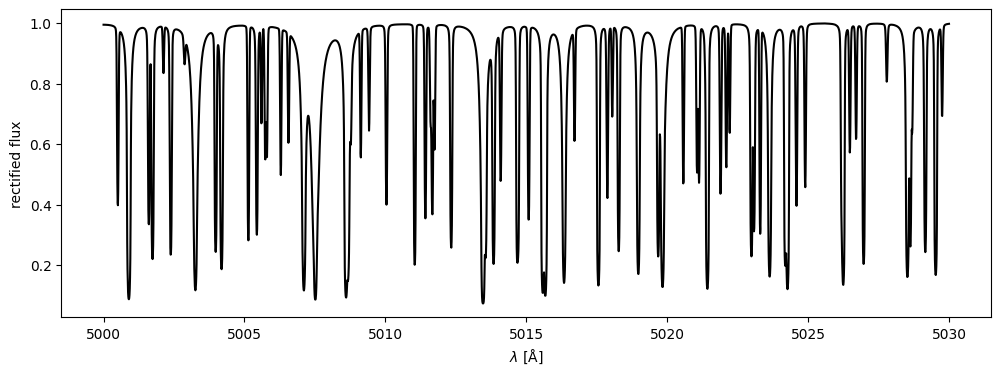

In [15]:
figure(figsize=(12, 4))
plot(sol.wavelengths, sol.flux ./ sol.cntm, "k-") # "./" is how you do element-wise division in Julia
xlabel(L"$\lambda$ [Å]")
ylabel("rectified flux");

## Specifying abundances

Let's synthesize spectra with varied abundances and take a look at the results.
Korg takes in a vector of abundances for all elements from H to U in $A(X)$ format. The `format_A_X` function provies an easy way to do this. The first argument specifies the default `[X/H]` abundance, the second lets you specify the default `[alpha/H]` abundance, and the third lets you specify individual abundances.


In [16]:
metal_poor_A_X = format_A_X(-0.5) # [M/H] = -1/2
alpha_rich_A_X = format_A_X(0, 0.5) # all [M/H] = 0, but [alpha/H] = 0.5]
Ni_enriched_A_X = format_A_X(Dict("Ni"=>1.0)) # all [M/H] = 0, except [Ni/H] = 1.0
;

Note that the resulting [M/H] for each vector is **not** the same at the default value you provided, unless you didn't set any other abundances.

In [17]:
println(Korg.get_metals_H(metal_poor_A_X))
println(Korg.get_metals_H(alpha_rich_A_X)) # particularly close to [α/H] because light alphas dominate the metal content
println(Korg.get_metals_H(Ni_enriched_A_X))

-0.5000009370397471
0.47053572460965576
0.00568615453494381


In order to make sure that the model atmosphere abundances match the synthesis abundances, we pass `A_X` vectors directly to `interpolate_marcs`.

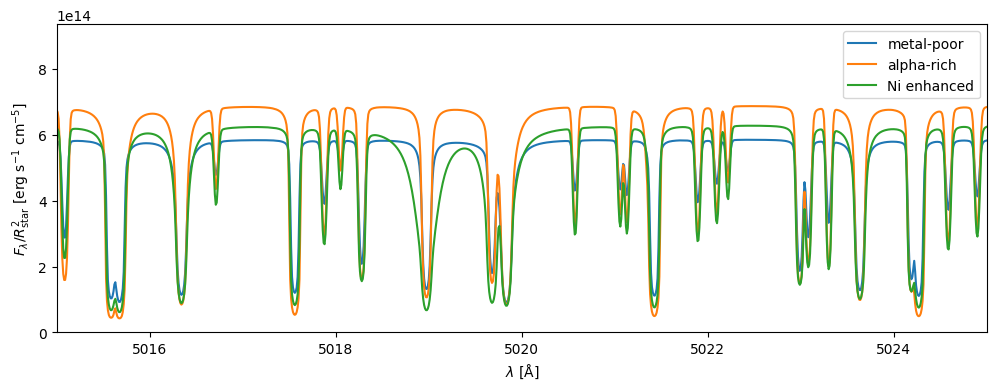

In [18]:
metal_poor_atm = interpolate_marcs(5221, 4.32, metal_poor_A_X)
metal_poor_sol = synthesize(metal_poor_atm, lines, metal_poor_A_X, 5015, 5025)

alpha_rich_sol = interpolate_marcs(5221, 4.32, alpha_rich_A_X)
alpha_rich_sol = synthesize(alpha_rich_sol, lines, alpha_rich_A_X, 5015, 5025)

Ni_enriched_atm = interpolate_marcs(5221, 4.32, Ni_enriched_A_X)
Ni_enriched_sol = synthesize(Ni_enriched_atm, lines, Ni_enriched_A_X, 5015, 5025)

figure(figsize=(12, 4))
plot(metal_poor_sol.wavelengths, metal_poor_sol.flux, label="metal-poor")
plot(alpha_rich_sol.wavelengths, alpha_rich_sol.flux, label="alpha-rich")
plot(Ni_enriched_sol.wavelengths, Ni_enriched_sol.flux, label="Ni enhanced")

xlabel(L"$\lambda$ [Å]")
ylabel(L"$F_\lambda/R_\mathrm{star}^2$ [erg s$^{-1}$ cm$^{-5}$]")
xlim(5015, 5025)
ylim(0, ylim()[2]*1.3) # make a little room on top for the legend
legend();

## Other data returned by `synthesize`

`sol.alpha` is a matrix containing the absorption coefficient, $\alpha$ at each wavelength and atmospheric layer.  We can plot $\alpha$ as a function of wavelength like this.

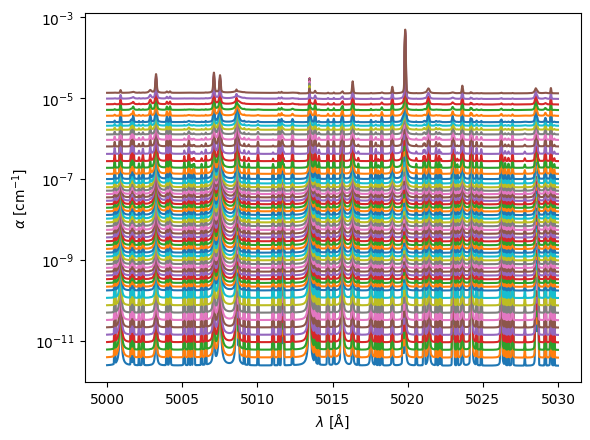

In [19]:
plot(sol.wavelengths, sol.alpha'); # sol.alpha' is the adjoint of sol.alpha.
yscale("log")
xlabel(L"$\lambda$ [Å]")
ylabel(L"$\alpha$ [cm$^{-1}$]");

(`sol.intensity` contains $I$ at each wavelength and atmospheric layer in the same format at `sol.alpha`.)

Let's look at the last bit of info that synthesize returns.  `sol.number_densities` is a dictionary which maps Korg `Species` objects to their number densities in each layer of the atmosphere.

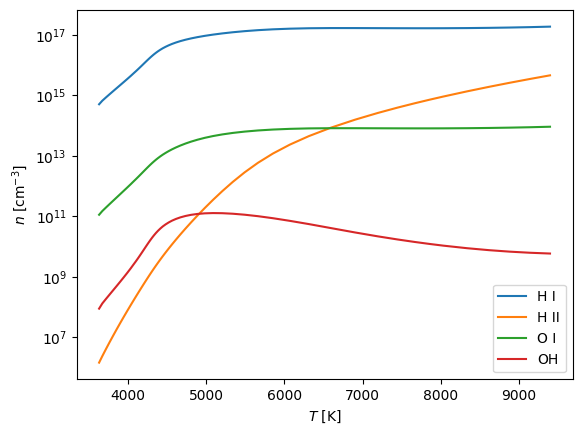

In [20]:
temps = Korg.get_temps(dwarf_atm)

# These strings represent different species. Below, we pass them to Korg.Species to construct a Species object.
for spec in ["H I", "H II", "O I", "OH"] 
    plot(temps, sol.number_densities[Korg.Species(spec)], label=spec)
end

legend()
yscale("log")
xlabel(L"$T$ [K]")
ylabel(L"$n$ [cm$^{-3}$]");